# TA Analysis: Improve PSF Centering

In high-contrast imaging, pinpointing the star's location hidden behind the coronographic mask is essential for accurate point spread function (PSF) subtraction. Currently, SpaceKLIP addresses this challenge by simulating the star's PSF behind the coronagraph using WebbPSF. This simulated PSF is then cross-correlated with the observed PSF, and the cross-correlation peak reveals the star's offset relative to the mask center. 

Here, we introduce a new method for determining the star's location behind the coronagraphic mask by incorporating Target Acquisition (TA) data. TA is a precise procedure that measures the centroid of a source and accurately positions it within a predefined aperture or subarray. Using this centroid information, we can adjust the target World Coordinate System (WCS) to reflect a more accurate estimate of its position relative to the coronagraphic mask. This method should improve the PSF centering and simplify the alignment process for NIRCam and MIRI data.

This notebook describes how the new `recenter_frames_ta` function—part of SpaceKLIP's `ImageTools` class—leverages TA data to compute and apply the necessary offsets to the target coordinates. This notebook can be run on NIRCam or MIRI data with TA images. 

## Table of Contents

* [1. Imports](#1.-Imports)
* [2. Query for TA Image(s)](#2.-Query-for-TA-Image(s))
* [3. Plot TA Image(s)](#3.-Plot-TA-Image(s))
* [4. TA Centroid Measurements](#4.-TA-Centroid-Measurements)
    * [4.1 Query OSS Log](#4.1-Query-OSS-Log)
    * [4.2 Plot OSS Centroid](#4.2-Plot-OSS-Centroid)
* [5. TA World Coordinate System](#5.-TA-World-Coordinate-System)
    * [5.1 Plot Target Coordinates from WCS](#5.1-Plot-Target-Coordinates-from-WCS)
* [6. Calculate OSS/WCS Offset](#6.-Calculate-OSS/WCS-Offset)
* [7. Conclusion](#7.-Conclusion)

---

## 1. Imports

In [1]:
# General imports.
import numpy as np
import matplotlib.pyplot as plt

# Astropy: for FITS file handling, units, etc.
import astropy
import astropy.units as u
from astropy.io import fits

# JWST modules: for working with JWST data models and adjusting WCS information.
import jwst.datamodels as datamodels
from jwst.tweakreg.utils import adjust_wcs

# SpaceKLIP modules.
import spaceKLIP.engdb as engdb
import spaceKLIP.target_acq_tools as target_acq_tools
import spaceKLIP.utils as utils

---
## 2. Query for TA Image(s)

To locate the associated TA images for a given observation, we must provide `get_visit_ta_image` with a visit ID and the instrument's name. We provide calibrated Stage 2 products from the NIRCam and MIRI tutorial demo data and extract the required information from the header.


In [2]:
# cal_product = './jw01386001001_0310e_00001_nrcalong_calints.fits' # NIRCam
cal_product = './jw01386007001_04101_00001_mirimage_calints.fits' # MIRI

In [3]:
visitid = 'V'+fits.getval(cal_product, 'VISIT_ID')
instrument = fits.getval(cal_product, 'INSTRUME')

In [4]:
# Images are saved in memory not to disk.
ta_images = target_acq_tools.get_visit_ta_image(visitid, inst=instrument)

Querying MAST for target acquisition files (visit V01386007001)
Found 2 target acquisition image(s).
TA file: jw01386007001_02101_00001_mirimage_cal.fits
TA file: jw01386007001_02101_00002_mirimage_cal.fits


---

## 3. Plot TA Image(s)


Some observations have multiple TA images. We display the first one by default.

In [5]:
# If there are multiple TA images (like with MIRI) define what TA image to plot.
ta_expnum = 1  # default.


Call `show_ta_img` with the visit ID and instrument name to display the TA image. This function lets you choose which TA image to display when multiple are available, and it also offers an option to mark the Science Instrument Aperture File (SIAF) reference point—which indicates the intended target position within that aperture's field of view.

Optionally, `show_ta_img` returns handles that we use later to add additional details to the TA image plot.


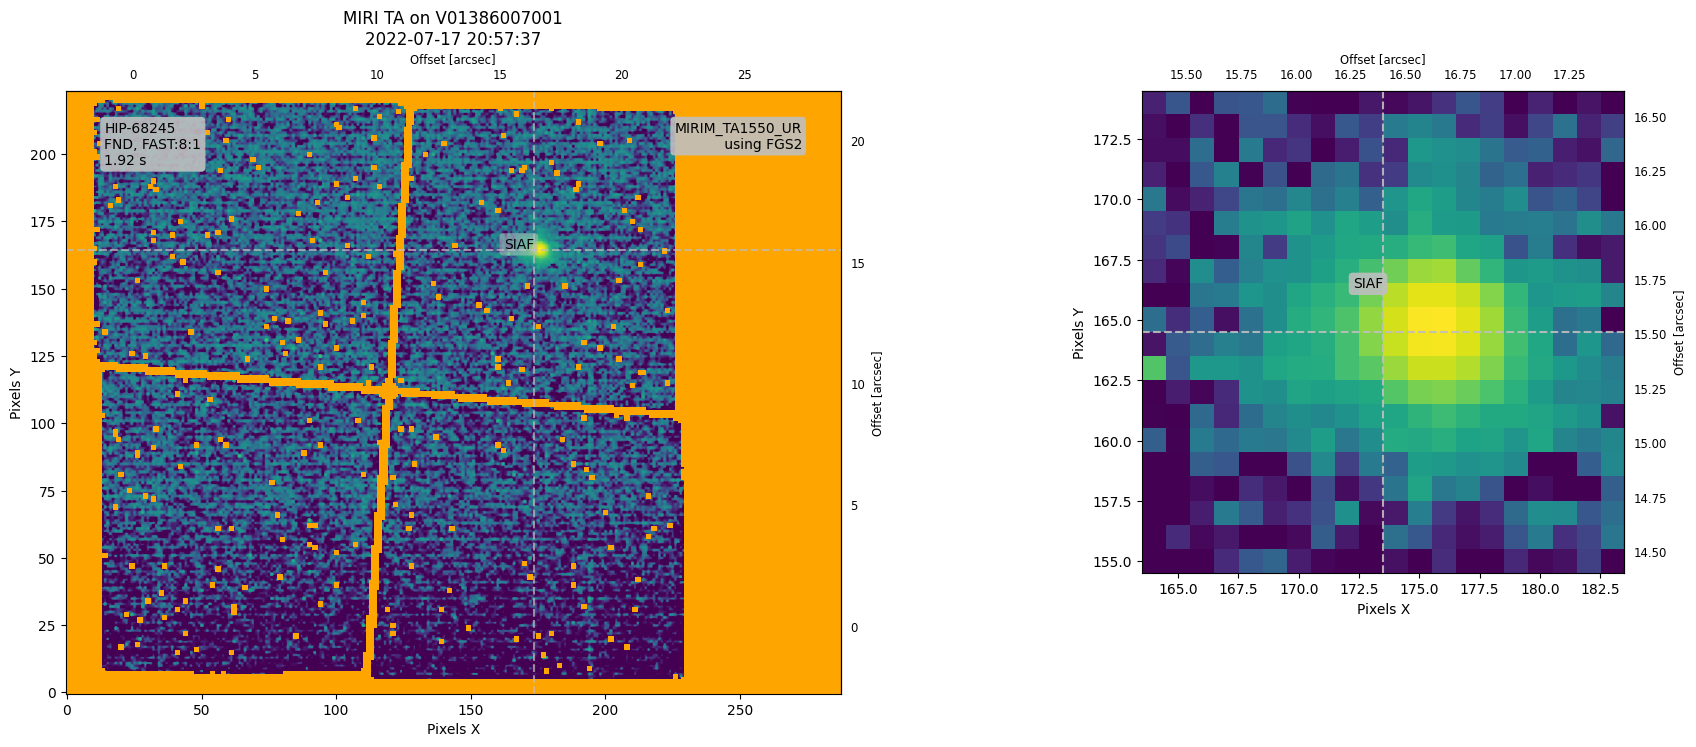

In [6]:
# Plot the TA image(s).
(ta_image_hdul,
 ax, norm,
 cmap, bglevel,
 inset_axes) = target_acq_tools.show_ta_img(visitid,
                                            inst=instrument,
                                            return_handles=True,
                                            ta_expnum=ta_expnum, # if multiple images.
                                            mark_reference_point=True,
                                            mark_apername=True,
                                            zoom=20)  # zoom width around SIAF center.

In the plot above, the SIAF reference point—indicated by the gray hash lines—is obtained using the `get_siaf` function. Here's how it works:

In [7]:
# Retrieve the TA aperture and reference point.
siaf = utils.get_siaf(instrument)
ta_aperture = siaf.apertures[ta_image_hdul[0].header['APERNAME']]
# This should match the label in the plots above.
print(f"The TA aperture is {ta_aperture.AperName}")

# Extract reference coordinates.
xref, yref = ta_aperture.XSciRef - 1, ta_aperture.YSciRef - 1  # 1-indexed
print (f"Intended Target Position (from SIAF) = {xref, yref} pix")

The TA aperture is MIRIM_TA1550_UR
Intended Target Position (from SIAF) = (23.5, 23.5) pix


---

## 4. TA Centroid Measurements

The centroid calculated during TA is performed in real-time onboard the spacecraft and is recorded in the Onboard Science Software (OSS) log. This information is not included in the science data products, so to access the centroid data, we must retrieve the corresponding OSS log. 


### 4.1 Query OSS Log 

We use the `get_ictm_event_log` function to retrieve the OSS log for this visit. This function queries the engineering database for an event log that falls within the time range of the TA observation. The start and end times of the TA are extracted from the FITS header (VSTSTART and VISITEND) and passed as arguments. 


In [8]:
ta_start = ta_image_hdul[0].header['VSTSTART']
ta_end = ta_image_hdul[0].header['VISITEND']

osslog = engdb.get_ictm_event_log(ta_start, ta_end)
osslog  # Returns a table of lines from the log.

<Table length=177>
           Time            ...
          str26            ...
-------------------------- ...
2022-07-17 20:48:04.068000 ...
2022-07-17 20:48:08.164000 ...
2022-07-17 20:48:17.380000 ...
2022-07-17 20:48:18.404000 ...
2022-07-17 20:48:20.452000 ...
2022-07-17 20:48:22.500000 ...
2022-07-17 20:48:24.548000 ...
2022-07-17 20:53:12.292000 ...
2022-07-17 20:53:12.292000 ...
                       ... ...
2022-07-17 22:19:47.039000 ...
2022-07-17 22:19:57.983000 ...
2022-07-17 22:20:00.351000 ...
2022-07-17 22:20:00.351000 ...
2022-07-17 22:20:01.375000 ...
2022-07-17 22:20:01.375000 ...
2022-07-17 22:20:02.399000 ...
2022-07-17 22:20:20.831000 ...
2022-07-17 22:20:29.023000 ...
2022-07-17 22:20:30.047000 ...

The OSS log contains much information, some of which isn't directly related to TA. To filter through the log and extract only the TA-related centroid data, we use `extract_oss_TA_centroids`. If multiple TA images exist, the function should output centroid information for each. 

**Note**: The OSS measures centroids in full-frame coordinates (2048 x 2048).  

In [9]:
oss_cen = engdb.extract_oss_TA_centroids(osslog, visitid)

# Determine centroid if multiple TAs.
oss_cen = oss_cen[ta_expnum-1] if ta_expnum else oss_cen[0]
print(f"OSS centroid(s) on board (x, y) [pix]:  "
      f"{oss_cen}  (full det coord frame, 1-based)")


Extracted date and time: 2022-07-17 20:58:52.26
Extracted Centroid Coordinates: (176.660706, 627.716717)

Extracted date and time: 2022-07-17 21:01:20.73
Extracted Centroid Coordinates: (133.605014, 587.471505)
OSS centroid(s) on board (x, y) [pix]:  (176.660706, 627.716717)  (full det coord frame, 1-based)


Let's convert from full-frame (as used by OSS) to the TA detector subarray coordinates:


In [10]:
# For MIRI only, deal with the fact that the image data
# can be full array even if the aperture is subarray.
if instrument == 'MIRI':
    subarray = ta_image_hdul[0].header['SUBARRAY']
    full_ap = siaf["MIRIM_FULL"]
    if subarray == 'FULL':
        aperture = full_ap
    elif subarray == 'SLITLESSPRISM':
        # Special case: pointed wusing TASLITLESSPRISM but SLITLESSPRISM readout.
        aperture = siaf['MIRIM_SLITLESSPRISM']
    elif subarray.startswith('MASK'):
        aperture = siaf['MIRIM_' + subarray]
    else:
        aperture = ta_aperture
else:
    aperture = ta_aperture

# Convert the centroid from detector to TA subarray coordinates.
oss_cen_sci = np.asarray(aperture.det_to_sci(*oss_cen))
# Convert from 1-based pixel indexing to 0-based.
oss_cen_sci_pythonic = oss_cen_sci - 1
print(f"OSS centroid converted (x, y) [pix]: {oss_cen_sci_pythonic}  "
      f"(sci frame in {aperture.AperName}, 0-based)")

OSS centroid converted (x, y) [pix]: [175.660706 164.716717]  (sci frame in MIRIM_MASK1550, 0-based)



### 4.2 Plot OSS Centroid 

Now that we have converted the OSS centroid to the TA coordinate system (and adjusted it to 0-based indexing), we can overlay this point onto our TA image.


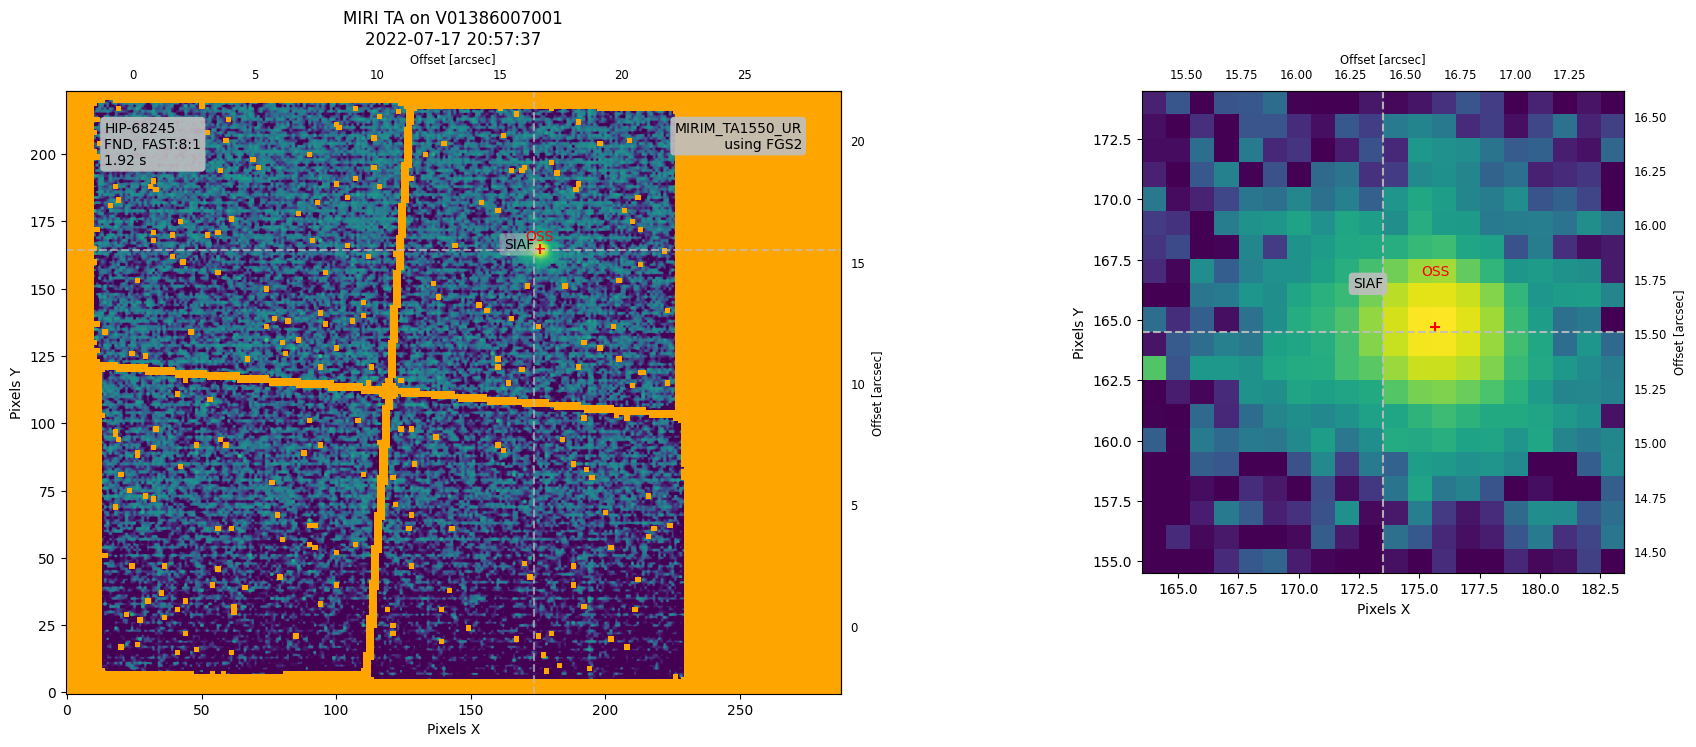

In [11]:
# Update the TA image with the OSS centroid.
fig = ax.get_figure()
for a in (ax, inset_axes):
    a.scatter(oss_cen_sci_pythonic[0], oss_cen_sci_pythonic[1],
              color='red', marker='+', s=50)
    a.text(oss_cen_sci_pythonic[0], oss_cen_sci_pythonic[1] + 2, 'OSS',
           color='red', verticalalignment='bottom',
           horizontalalignment='center')
fig

---

## 5. TA World Coordinate System

Next, we examine the TA World Coordinate System (WCS) to determine where it places the target within the aperture. By comparing this position to the OSS-derived centroid, we can determine the necessary WCS adjustments to align the two points if an offset is present.


In [12]:
# Create a SkyCoord object for the target coordinates (RA, Dec) in ICRS frame.
ta_model = datamodels.open(ta_image_hdul)

targ_coords = astropy.coordinates.SkyCoord(
    ra=ta_model.meta.target.ra,
    dec=ta_model.meta.target.dec,
    frame='icrs',
    unit=u.deg
)

In [13]:
# Convert celestial coordinates (RA, Dec) to pixel coordinates using WCS.
wcs_ta = ta_model.meta.wcs

targ_coords_pix = wcs_ta.world_to_pixel(targ_coords)  # Returns (x, y).
print(f"Target Coordinates based on WCS (x, y): "
      f"({targ_coords_pix[0]:.2f}, {targ_coords_pix[1]:.2f})")

Target Coordinates based on WCS (x, y): (173.04, 164.77)


### 5.1 Plot Target Coordinates from WCS  

Update the TA image plot by overlaying the target coordinate derived from the WCS.

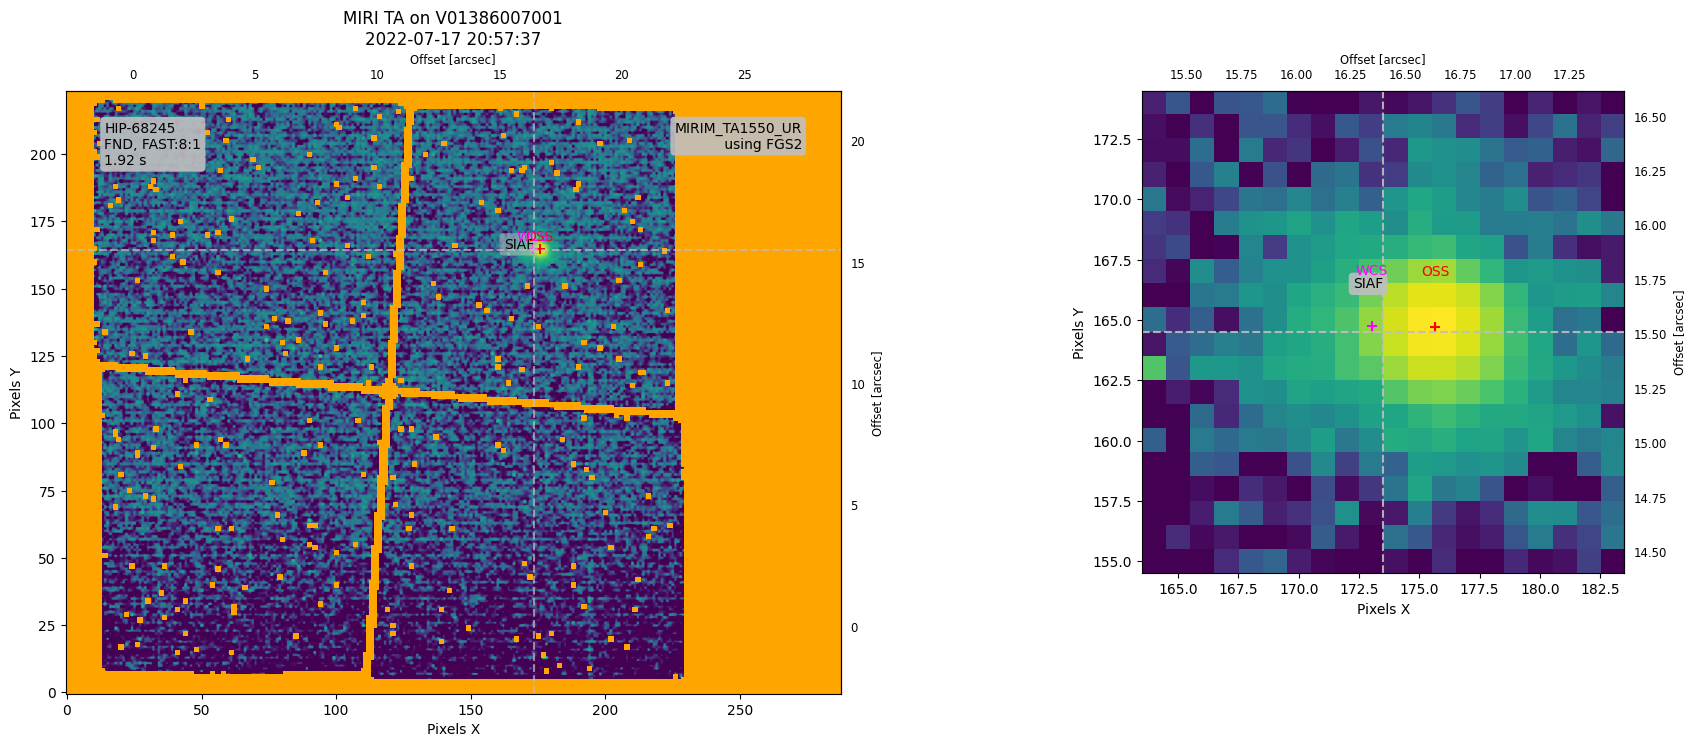

In [14]:
# Update the TA image with the WCS target coordinate.
fig = ax.get_figure()
for a in (ax, inset_axes):
    a.scatter(targ_coords_pix[0], targ_coords_pix[1],
           color='magenta', marker='+', s=50)
    a.text(targ_coords_pix[0], targ_coords_pix[1] + 2, 'WCS',
            color='magenta', verticalalignment='bottom',
            horizontalalignment='center')
fig

---

## 6. Calculate OSS/WCS Offset

In this section, we compute the offset between the OSS-derived centroid and the target coordinate from the TA WCS. 

In [15]:
# --- Compute initial offsets RA/DEC (WCS -> OSS) ---
ta_cen_coords = wcs_ta.pixel_to_world(*oss_cen_sci_pythonic)
dra = targ_coords.ra - ta_cen_coords.ra
ddec = targ_coords.dec - ta_cen_coords.dec
original_wcs_offset_radec = (dra.to(u.arcsec), ddec.to(u.arcsec))
print(f"Initial TA WCS offset (RA, DEC) = {original_wcs_offset_radec[0]:.3f}, "
      f"{original_wcs_offset_radec[1]:.3f} (WCS - OSS)")

# --- Compute pixel offset (WCS -> OSS) ---
wcs_offset_pix = np.asarray(targ_coords_pix) - oss_cen_sci_pythonic
print(f"Initial TA WCS offset (x, y) [pix] = {wcs_offset_pix[0]:.3f}, "
      f"{wcs_offset_pix[1]:.3f} (WCS - OSS)")

Initial TA WCS offset (RA, DEC) = -0.120 arcsec, -0.274 arcsec (WCS - OSS)
Initial TA WCS offset (x, y) [pix] = -2.617, 0.052 (WCS - OSS)


Now that we’ve computed the offset, we can use `adjust_wcs` to update the TA WCS so that the target coordinates align with the OSS centroid.


In [16]:
# Adjust the WCS from delta RA/DEC.
wcs_ta_adj = adjust_wcs(wcs_ta, *original_wcs_offset_radec)

Let's recompute the target coordinates using the adjusted TA WCS. 

In [17]:
# --- Recompute Coordinates using Adjusted TA WCS ---

# Compute the adjusted target centroid in world coordinates.
ta_cen_coords_adj = wcs_ta_adj.pixel_to_world(*oss_cen_sci_pythonic)

# Compute the adjusted target coordinates in pixel space.
targ_coords_pix_adj = wcs_ta_adj.world_to_pixel(targ_coords)
residual_pix = np.asarray(targ_coords_pix_adj) - oss_cen_sci_pythonic
print(f"Residual WCS/OSS offset (x, y) [pix] = "
      f"{residual_pix[0]:.3f}, {residual_pix[1]:.3f}")

# Convert the adjusted pixel coordinates back to world coordinates.
targ_coords_adj = wcs_ta_adj.pixel_to_world(*targ_coords_pix_adj)
dra_residual = targ_coords_adj.ra - ta_cen_coords_adj.ra
ddec_residual = targ_coords_adj.dec - ta_cen_coords_adj.dec
residual_radec = (dra_residual.to(u.arcsec), ddec_residual.to(u.arcsec))
print(f"Residual WCS/OSS offset (RA, DEC) [arcsec] = "
      f"{residual_radec[0]:.6f}, {residual_radec[1]:.6f}")

# Print the final adjusted target coordinates.
print(f"Adjusted Target coordinates (RA, Dec) [deg] = "
      f"{targ_coords_adj.ra.deg:.6f}, {targ_coords_adj.dec.deg:.6f}")
print(f"TA Target coordinates from Adjusted WCS (x, y) [pix] = "
      f"{targ_coords_pix_adj[0]:.3f}, {targ_coords_pix_adj[1]:.3f}")

Residual WCS/OSS offset (x, y) [pix] = -0.002, -0.008
Residual WCS/OSS offset (RA, DEC) [arcsec] = -0.001204 arcsec, 0.000061 arcsec
Adjusted Target coordinates (RA, Dec) [deg] = 209.567586, -42.100881
TA Target coordinates from Adjusted WCS (x, y) [pix] = 175.659, 164.709


Finally, update the TA image plot by overlaying the target coordinate derived from the adjusted WCS.


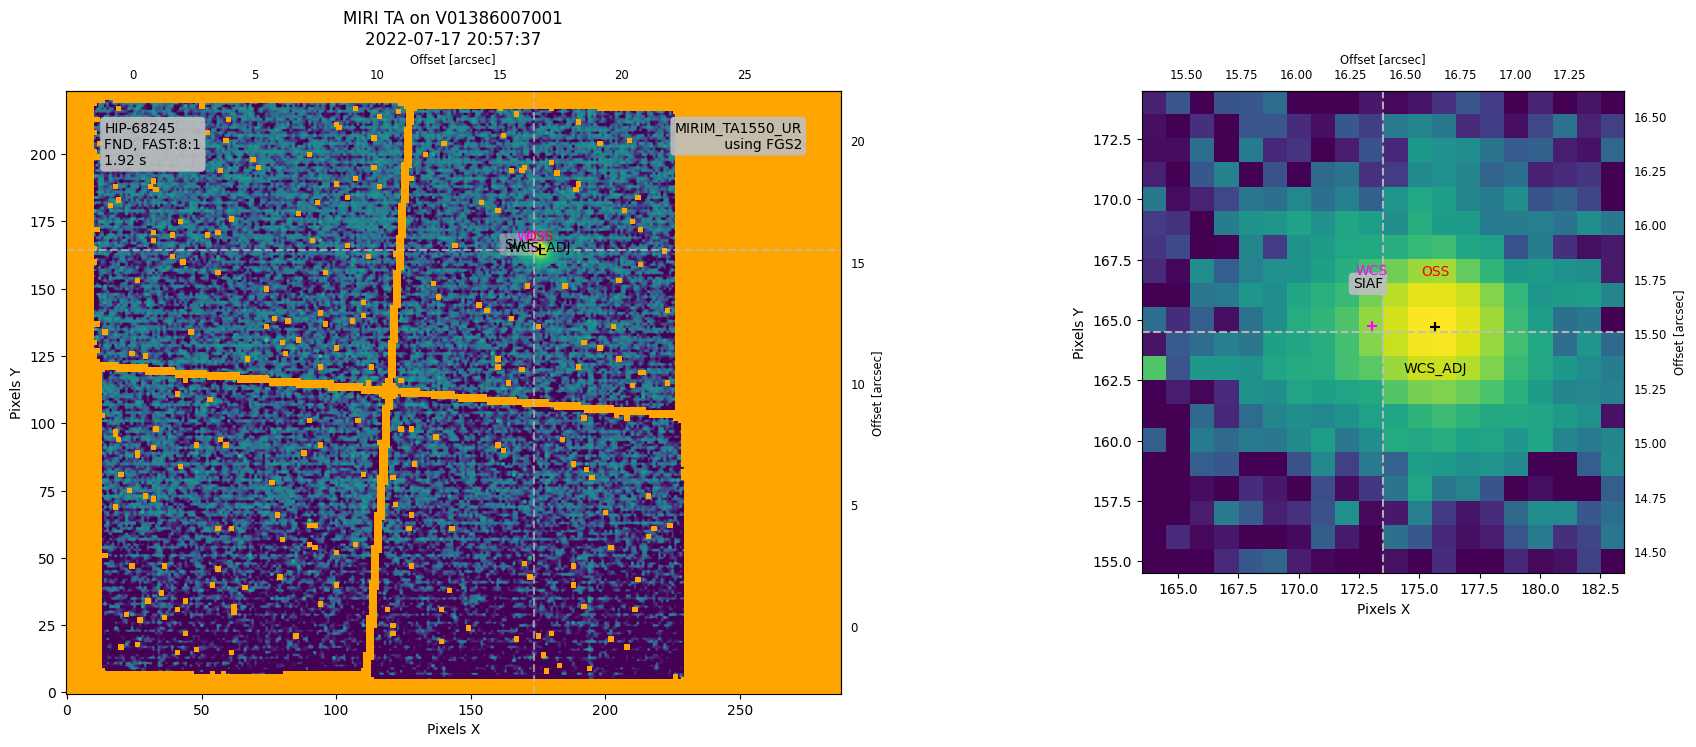

In [18]:
# Update the TA image with the WCS target coordinate.
fig = ax.get_figure()
for a in (ax, inset_axes):
    a.scatter(targ_coords_pix_adj[0], targ_coords_pix_adj[1],
           color='black', marker='+', s=50)
    a.text(targ_coords_pix_adj[0], targ_coords_pix_adj[1] - 2, 'WCS_ADJ',
            color='black', verticalalignment='bottom',
            horizontalalignment='center')
fig

---

## 7. Conclusion

All the steps described in the previous sections are performed automatically in the `ta_analysis` routine—provided you supply a FITS file with the necessary header information (instrument name and visit ID). The `ta_analysis` also returns the adjusted science target coordinate in pixels (in the science aperture).


Extracted date and time: 2022-07-17 20:58:52.26
Extracted Centroid Coordinates: (176.660706, 627.716717)

Extracted date and time: 2022-07-17 21:01:20.73
Extracted Centroid Coordinates: (133.605014, 587.471505)
175.5227810246255 164.60125373457328

------TA Target Information------
TA Target coordinates (RA, Dec) [deg]: (209.567586, -42.100881)
TA Target (hms | dms): 13:58:16.22069108 -42:06:03.17177105
TA Target coordinates from WCS (x, y) [pix]: 173.044, 164.769


------TA OSS Centroid Information------
TA Target centroid coordinates (RA, Dec) [deg]: (209.567620, -42.100805)
OSS centroid on board (x, y):  (176.660706, 627.716717)  (full det coord frame, 1-based)
OSS centroid converted (x, y): [175.660706 164.716717] (sci frame in MIRIM_TA1550_UR, 0-based)
OSS centroid converted (x, y): [175.660706 626.716717] (sci frame in MIRIM_FULL, 0-based)


------Offset Information------
TA WCS offset (x, y) [pix] = -2.617, 0.052 (WCS - OSS)
TA ΔRA, ΔDEC = -0.120 arcsec, -0.274 arcsec (WCS - OS

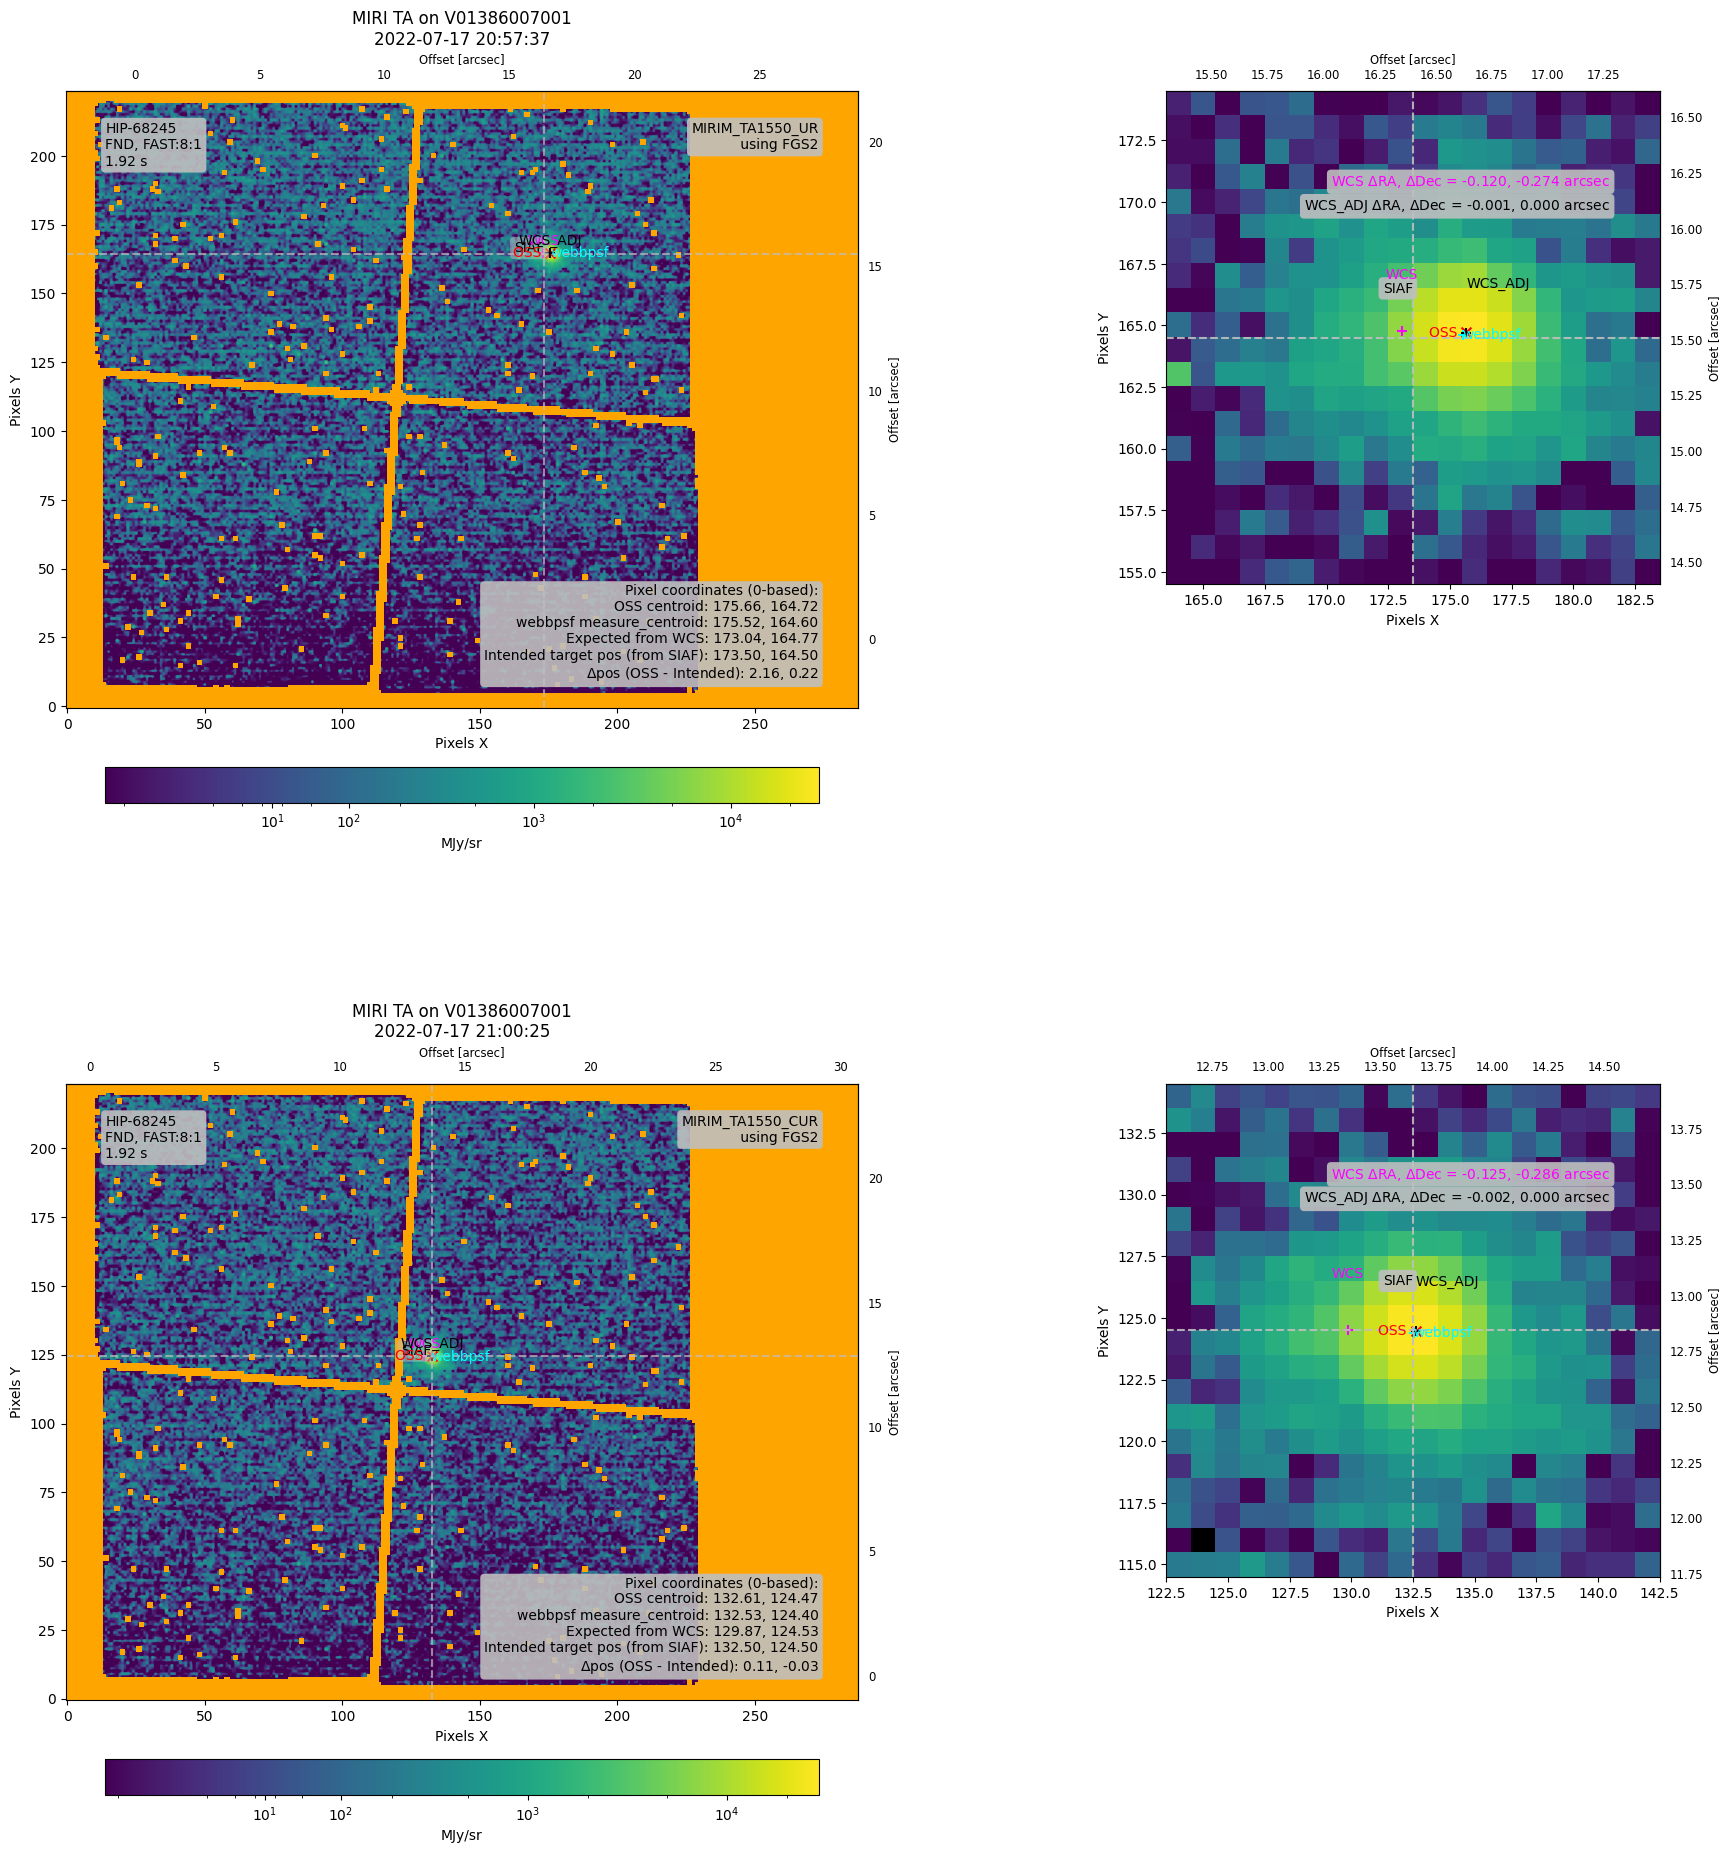

In [19]:
targ_coords_pix_adj_sci = target_acq_tools.ta_analysis(cal_product,
                                                       verbose=True,
                                                       plot=True)

As a last check, let's plot the adjusted target coordinates in the SCI frame.

The SCI aperture is MIRIM_MASK1550


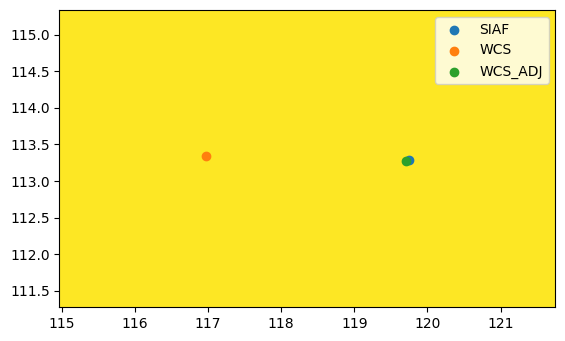

In [20]:
cal = datamodels.open(cal_product)
cal_data = cal.data[0]

targ_coords_pix_sci = cal.meta.wcs.world_to_pixel(targ_coords)  # Returns (x, y).

sci_aperture = siaf.apertures[cal.meta.aperture.name]
xref_sci, yref_sci = sci_aperture.XSciRef - 1, sci_aperture.YSciRef - 1  # 1-indexed
# This should match the label in the plots above.
print(f"The SCI aperture is {sci_aperture.AperName}")

plt.imshow(cal_data, vmin=np.nanpercentile(cal_data, 5),
           vmax=np.nanpercentile(cal_data, 80), origin='lower')
plt.scatter(xref_sci, yref_sci, label='SIAF')
plt.scatter(*targ_coords_pix_sci, label='WCS')
plt.scatter(targ_coords_pix_adj_sci[0], targ_coords_pix_adj_sci[1], label='WCS_ADJ')

# Collect all scatter points into arrays
all_x = [xref_sci, targ_coords_pix_sci[0], targ_coords_pix_adj_sci[0]]
all_y = [yref_sci, targ_coords_pix_sci[1], targ_coords_pix_adj_sci[1]]

# Automatically set limits with padding
padding = 2 # Add some padding to the limits
plt.xlim(min(all_x) - padding, max(all_x) + padding)
plt.ylim(min(all_y) - padding, max(all_y) + padding)
plt.legend()

We can use the method in the `recenter_frames_ta` function (part of SpaceKLIP's `ImageTools` class) to refine the PSF center before PSF subtraction.











